# Lesson 1 Homework - Seedling Classification

## Initializtion

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

Let's start with a batch sixe of 48, and decrease it later if neccessary

In [99]:
bs = 48

Select an image size of `336`. I experimented with image sizes of 224, 200, and 336. Ultimately the higher image sizes led to better results.

In [28]:
path = './data/seedlings'
image_size = 336

Load the images into an `ImageDataBunch` object. Since there are no separate `train`, `valid`, and `test`, folders, I had to use the solution documented [here] https://forums.fast.ai/t/unable-to-create-imagedatabunch-from-folders/36923.

In [30]:
tfms = get_transforms(do_flip=False)
data = (
    ImageList.from_folder(path)
    .split_by_rand_pct()
    .label_from_folder()
    .transform(tfms, size=image_size)
    .databunch()
)

Let's take a look at some of the images.

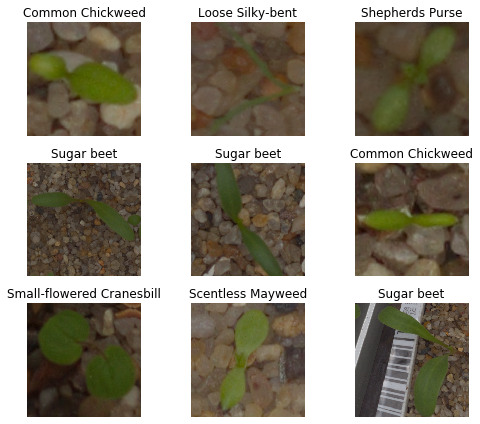

In [31]:
data.show_batch(rows=3, figsize=(7,6))

## Restnet34 Learner

Create the leaner, run for 4 cycles, and save the output

In [32]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [33]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.133650,0.654572,0.203158,00:33
1,1.111065,0.381189,0.117895,00:32
2,0.702904,0.312537,0.106316,00:33
3,0.497388,0.278614,0.100000,00:34


In [34]:
learn.save('stage-1')

Let's look at the top losses, confusion matrix, and most confused.

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

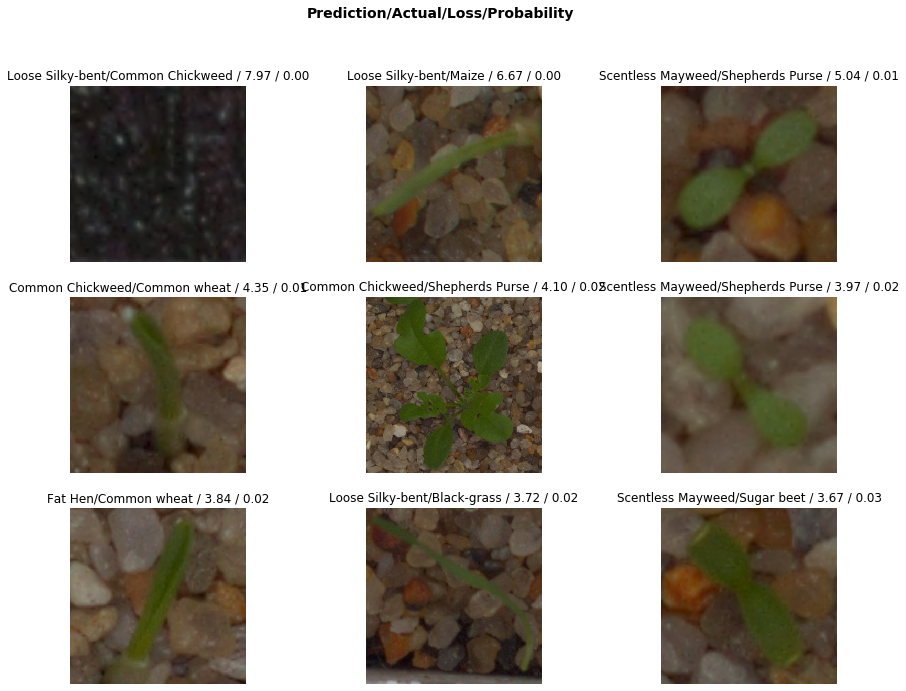

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

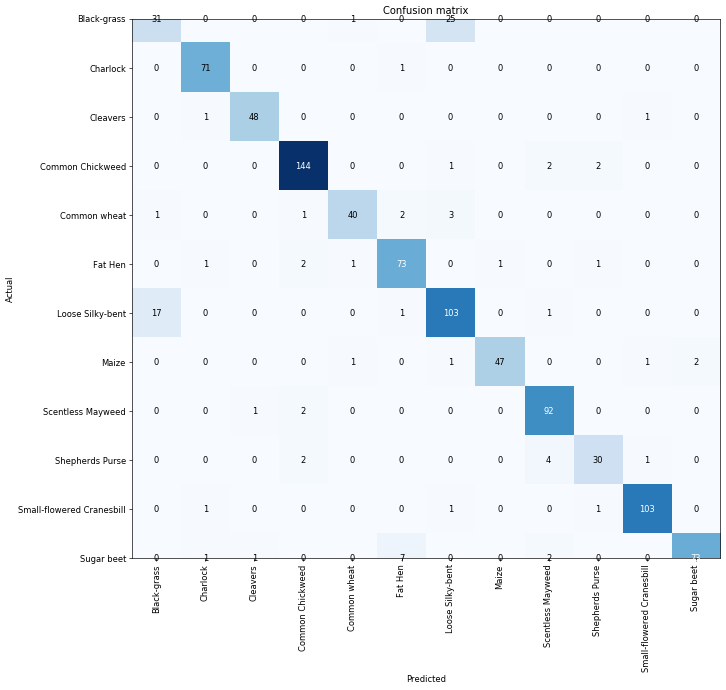

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 25),
 ('Loose Silky-bent', 'Black-grass', 17),
 ('Sugar beet', 'Fat Hen', 7),
 ('Shepherds Purse', 'Scentless Mayweed', 4),
 ('Common wheat', 'Loose Silky-bent', 3),
 ('Common Chickweed', 'Scentless Mayweed', 2),
 ('Common Chickweed', 'Shepherds Purse', 2),
 ('Common wheat', 'Fat Hen', 2),
 ('Fat Hen', 'Common Chickweed', 2),
 ('Maize', 'Sugar beet', 2),
 ('Scentless Mayweed', 'Common Chickweed', 2),
 ('Shepherds Purse', 'Common Chickweed', 2),
 ('Sugar beet', 'Scentless Mayweed', 2)]

It looks like `Black-grass` and `Loose Silky-bent` are the most difficult to tell apart.

Let's try to improve the model. First, let's plot the learning-rate vs. loss relationship.

In [41]:
learn.load('stage-1');

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


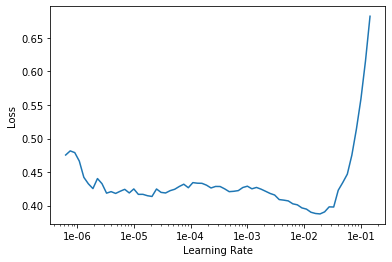

In [43]:
learn.recorder.plot()

Anything smaller than `1e-2` appears to have a very low loss. Let's unfreeze the model and train it some more with the range `1e-05`-`1e-03` which appears to be well within the low-loss range.

In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.224655,0.148305,0.048421,00:33
1,0.164702,0.135851,0.049474,00:33


That's pretty good! Now, let's try the same thing, but with a resnet50 architecture.

## Resnet50 Learner

In [48]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


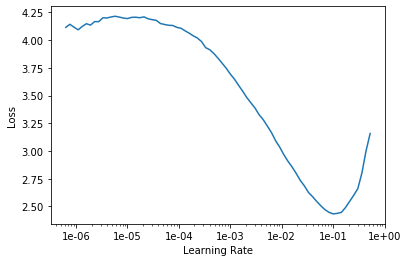

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.965255,0.771701,0.231579,00:42
1,1.087736,0.337678,0.117895,00:40
2,0.675783,0.329253,0.100000,00:40
3,0.462798,0.202064,0.077895,00:40
4,0.323767,0.184216,0.060000,00:41
5,0.245156,0.199652,0.071579,00:40
6,0.180106,0.153159,0.046316,00:39
7,0.149588,0.148376,0.048421,00:39


In [52]:
learn.save('stage-1-50')

We got a `4.8%` error compared to the `10%` when using `resnet34`. Let's try to unfreeze the learner and train the model some more.

In [53]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.196534,0.197285,0.065263,00:50
1,0.189166,0.126373,0.047368,00:49
2,0.110921,0.097637,0.035789,00:49


This gives us an error rate of 3.5%. Let's take a look at the most confused to see which types of seedlings are giving us trouble.

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

In [55]:
interp.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 16),
 ('Loose Silky-bent', 'Black-grass', 4),
 ('Black-grass', 'Common wheat', 2)]